# Import packages

In [ ]:
import finlab
# Read the API key from the text file
with open('credential.txt', 'r') as file:
    api_key = file.readline().strip()

# Use the API key to log in
finlab.login(api_key)

In [1]:
from finlab import data
import pandas as pd
import warnings
import requests

輸入成功!


In [2]:
import statsmodels.api as sm

In [3]:
import itertools

### Machine Learning

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [5]:
import tensorflow as tf
import keras

print(tf.__version__)  # 查看 TensorFlow 版本
print(keras.__version__)  # 查看 Keras 版本

2024-01-20 02:56:56.893267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0
2.15.0


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [7]:
from scikeras.wrappers import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.metrics import mean_squared_error

### 圖像化

In [9]:
import matplotlib.pyplot as plt

In [10]:
import matplotlib.dates as mdates

# Functions

### Beta迴圈

In [11]:
def get_data_for_period(dataframe, start_year, end_year):
    df_copy = dataframe.copy()
    if df_copy.columns[1] != '發行量加權股價報酬指數':
        df_copy['收盤價(元)'] = df_copy['收盤價(元)'].pct_change()
    else:
        df_copy['發行量加權股價報酬指數'] = df_copy['發行量加權股價報酬指數'].pct_change()

    # 創建時間段
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    # 確保日期列是日期的時間格式
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # 篩選出指定時間段內的數據
    filtered_data = df_copy[(df_copy['Date'] >= start_date) & (df_copy['Date'] <= end_date)]
    if df_copy.columns[1] != '發行量加權股價報酬指數':
        filtered_data = filtered_data[['Date', '收盤價(元)']]
    filtered_data = filtered_data.reset_index(drop=True)

    return filtered_data

### 依據時間切資料

In [12]:
def is_data_sufficient(dataframe, min_data_count):
    # return: 如果数据满足要求返回 True，否则返回 False。
    # 计算数据笔数
    data_count = len(dataframe)

    # 判断是否满足最小数据笔数要求
    return data_count >= min_data_count

### 篩選並踢除Beta值異常的股票。

In [13]:
def filter_extreme_betas(betas, threshold_factor=2):
    """
    :param betas: 一個包含股票代號和其Beta值的列表，格式為[(stock_code, beta), ...]。
    :param threshold_factor: 用於確定篩選閾值的倍數因子，預設為2。
    :return: 剔除異常Beta值的股票後的清單。
    """
    # 计算平均Beta值和标准差
    beta_values = [beta[1] for beta in betas]
    average_beta = sum(beta_values) / len(beta_values)
    std_dev_beta = (sum((x - average_beta) ** 2 for x in beta_values) / len(beta_values)) ** 0.5

    # 设定筛选阈值
    upper_threshold = average_beta + threshold_factor * std_dev_beta
    lower_threshold = average_beta - threshold_factor * std_dev_beta

    # 筛选并剔除异常Beta值的股票
    filtered_betas = [beta for beta in betas if lower_threshold <= beta[1] <= upper_threshold]

    return filtered_betas

### Cointegration test

In [14]:
def get_price_for_period(dataframe, start_year, end_year):
    df_copy = dataframe.copy()

    # 創建時間段
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    # 確保日期列是日期的時間格式
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    # 篩選出指定時間段內的數據
    filtered_data = df_copy[(df_copy['Date'] >= start_date) & (df_copy['Date'] <= end_date)]
    filtered_data = filtered_data['收盤價(元)']
    filtered_data = filtered_data.reset_index(drop=True)

    return filtered_data

### 定義協整測試函數

In [15]:
# 定义协整测试函数
def cointegration_test(stock1, stock2):
    # 确保两个DataFrame在日期上对齐
    stock1, stock2 = stock1.align(stock2, join='inner')

    # 提取价格数据
    # 假设每个DataFrame只包含一个列，代表股票价格
    # stock1_prices = stock1.iloc[:, 0]
    # stock2_prices = stock2.iloc[:, 0]

    # 进行线性回归
    model = sm.OLS(stock1, sm.add_constant(stock2)).fit()
    residuals = model.resid

    # 进行ADF检验
    adf_test = sm.tsa.adfuller(residuals)
    p_value = adf_test[1]

    return p_value

### Calculate spread

In [16]:
def calculate_spread(dataframe, stock_pair, start_year, end_year):
    # 提取两只股票的数据
    df_stock_1 = dataframe[dataframe['證券代碼'] == stock_pair[0]]
    df_stock_2 = dataframe[dataframe['證券代碼'] == stock_pair[1]]

    # 获取两只股票在指定时间段内的价格
    stock_1_prices = get_price_for_period(df_stock_1, start_year, end_year)
    stock_2_prices = get_price_for_period(df_stock_2, start_year, end_year)

    # print(stock_1_prices)
    # print(stock_2_prices)

    # 计算价差
    spread = stock_1_prices - stock_2_prices

    spread.dropna(inplace = True)

    return spread

### Get Overvalued and Undervalued Stocks

In [17]:
# if spread > 0, min_p_value_pair[0] > min_p_value_pair[1]
def get_overvalued_and_undervalued_stocks(dataframe, spread, stock_pair, year):
    # Calculate the spread
    spread = calculate_spread(dataframe, stock_pair, year, year)

    # Calculate the average spread over the year
    average_spread = spread.mean()

    if average_spread > 0:
        # stock_pair[0] is overvalued relative to stock_pair[1]
        overvalued_code = stock_pair[0]
        undervalued_code = stock_pair[1]
    else:
        # stock_pair[1] is overvalued relative to stock_pair[0]
        overvalued_code = stock_pair[1]
        undervalued_code = stock_pair[0]

    # Extract the prices for the overvalued and undervalued stocks
    df_overvalued = dataframe[dataframe['證券代碼'] == overvalued_code]
    df_undervalued = dataframe[dataframe['證券代碼'] == undervalued_code]
    prices_overvalued = get_price_for_period(df_overvalued, year, year)
    prices_undervalued = get_price_for_period(df_undervalued, year, year)

    return prices_overvalued, prices_undervalued

### Read the excel file of specific year

In [18]:
def read_and_extract_data_from_excel(year):
    # Construct the file name based on the year
    file_name = f'aggressive_stock_data_{year}.xlsx'
    
    # Read the data from the Excel file
    df_from_excel = pd.read_excel(file_name, dtype={'Stock Code 1': str, 'Stock Code 2': str})

    # Access the data as needed
    real_stock_spread = df_from_excel['Real Stock Spread'].values
    predicted_stock_spread = df_from_excel['Predicted Stock Spread'].values.reshape(-1, 1)  # Reshaping to maintain 2D

    # Pair the stock codes and p-values together
    stock_code_pair = (df_from_excel['Stock Code 1'][0], df_from_excel['Stock Code 2'][0])
    p_value_pair = (df_from_excel['P-value 1'][0], df_from_excel['P-value 2'][0])
    
    return df_from_excel, real_stock_spread, predicted_stock_spread, stock_code_pair, p_value_pair

### Plot the spread line

In [19]:
def plot_stock_spread(real_spread, predicted_spread, start_date, end_date):
    # Calculate Mean Squared Error
    mse = mean_squared_error(real_spread, predicted_spread)
    print(f"Mean Squared Error: {mse}")
    
    # Create an array of dates spanning the given date range, one for each data point
    dates = pd.date_range(start = start_date, periods = len(predicted_spread), end = end_date)

    # Calculate mean and standard deviation for the threshold
    mean_spread = np.mean(predicted_spread)
    std_spread = np.std(predicted_spread)
    threshold = 1.5 * std_spread

    # Plotting the real and predicted stock spread
    plt.figure(figsize=(12,6))
    plt.plot(dates, real_spread, color='red', label='Real Stock Spread')
    plt.plot(dates, predicted_spread, color='lime', label='Predicted Stock Spread')

    # Draw horizontal lines for the thresholds
    plt.axhline(y=mean_spread + threshold, color='blue', linestyle='--', label='Upper Threshold')
    plt.axhline(y=mean_spread - threshold, color='orange', linestyle='--', label='Lower Threshold')

    # Formatting the date labels on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate the dates for better readability

    plt.title('Stock Spread Prediction with MSE and Threshold Lines')
    plt.xlabel('Time')
    plt.ylabel('Stock Price Spread')
    plt.legend()
    plt.show()

### Plot the Equity Curve

In [124]:
def plot_equity_curve(dates, equity_curve, title):
    plt.figure(figsize=(14, 7))
    if title == "Combined Equity Curve Over Multiple Years":
        plt.figure(figsize=(20, 12))
    
    plt.plot(dates, equity_curve, label='Equity Curve', color='blue')
    
    # Set major locator to first day of each month and formatter to the specific date format
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    if title == "Combined Equity Curve Over Multiple Years":
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Improve the x-axis ticks readability
    plt.gcf().autofmt_xdate()
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Total Capital')
    plt.legend()
    plt.show()

### Generate the Equity Curve for a Specific Year

In [21]:
def generate_yearly_equity_curve(year, time_points, equity_curve):
    full_year_dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
    full_year_equity_curve = np.interp(
        np.linspace(0, len(time_points) - 1, num=len(full_year_dates)),
        time_points,
        equity_curve
    )
    return full_year_dates, full_year_equity_curve

### Cumulative profit, Total capital at risk, and Return rate

In [23]:
def calculate_equity_curve(initial_capital, spreads, prices_overvalued, prices_undervalued):
    # Calculating mean and standard deviation of spreads
    mean_spread = np.mean(spreads)
    std_spread = np.std(spreads)
    threshold = 1.5 * std_spread

    # Initial parameters
    nominal_capital = 1  # Nominal capital at risk per trade
    total_capital = initial_capital  # Starting with initial capital

    # Arrays to store data for plotting
    equity_curve = []  # Starting point of the equity curve
    time_points = []  # Corresponding time points

    # Track positions and other metrics
    positions = []
    profits = []
    total_capital_invested = 0
    total_shares_overvalued = 0
    total_shares_undervalued = 0

    is_trade_active = False
    check = False

    for i, spread in enumerate(spreads):
        num_shares_overvalued = nominal_capital / prices_overvalued[i] # 1 / prices_overvalued
        num_shares_undervalued = nominal_capital / prices_undervalued[i] # 1 / prices_undervalued
        if spread < 0:
            num_shares_overvalued = nominal_capital / prices_undervalued[i]
            num_shares_undervalued = nominal_capital / prices_overvalued[i]

        if (spread > mean_spread + threshold) or (spread < mean_spread - threshold):
            if i != len(spreads) - 1: # 這天一定出場
                # if 我這天出場:
                if is_trade_active == True:
                    pi = (total_shares_overvalued * prices_overvalued[i]) - (total_shares_undervalued * prices_undervalued[i])
                    pi = pi * (1 - 0.001425)
                    total_capital += (total_capital_invested + pi)
                    check = True
                # debug
                # print(f"Entering trade at index {i}, spread {spread}")
                # print(f"Overvalued shares: {num_shares_overvalued}, Undervalued shares: {num_shares_undervalued}")
                total_shares_overvalued += num_shares_overvalued
                total_shares_undervalued += num_shares_undervalued
                total_capital_invested += (nominal_capital * 1.001425)
                positions.append(i)  # Store the index of the trading day
                is_trade_active = True

                # Adjust total capital for trade entry
                total_capital -= (nominal_capital * 1.001425)
        if ((mean_spread - threshold <= spread <= mean_spread + threshold) and positions and is_trade_active == True) or (i == len(spreads) - 1 and positions and is_trade_active == True):
            # Exit trade
            exit_price_overvalued = prices_overvalued[i]  # Last day price
            exit_price_undervalued = prices_undervalued[i]  # Last day price
            pi = (total_shares_overvalued * exit_price_overvalued) - (total_shares_undervalued * exit_price_undervalued)
            pi = pi * (1 - 0.001425)
            profits.append(pi)
            positions.append(i)

            total_shares_overvalued = 0
            total_shares_undervalued = 0

            # debug
            # print(f"Exiting trade at index {i}, spread {spread}")
            # print(f"Profit from trade: {pi}")
            # print("----------------END----------------")
            is_trade_active = False
            check = False

            # Adjust total capital for trade exit
            total_capital += (total_capital_invested + pi)
            # Record the total capital and time point

        equity_curve.append(total_capital)
        time_points.append(i)

        if check == True:
            total_capital -= (total_capital_invested + pi)

    # Final calculations
    # len(positions) is Total number (days) of completed trades
    return_rate = (total_capital - initial_capital) / initial_capital if initial_capital != 0 else 0

    initial_capital = total_capital

    # Printing the required results
    # print(f"Cumulative profit: {sum(profits)}")
    print(f"交易天數: {len(positions)}")
    print(f"年化報酬率: {return_rate * 100}%")

    return time_points, equity_curve, initial_capital

# 抓資料

In [24]:
close=data.get("price:收盤價")

# 取得 OHLC 直式格式

price = close.T.stack().reset_index()
price.columns = ["證券代碼", "Date", "收盤價(元)"]
open = data.get("price:開盤價").T.stack().reset_index()
open.columns = ["證券代碼", "Date", "開盤價(元)"]
price = price.merge(open, on = ["證券代碼", "Date"])
high = data.get("price:最高價").T.stack().reset_index()
high.columns = ["證券代碼", "Date", "最高價(元)"]
price = price.merge(high, on = ["證券代碼", "Date"])
low = data.get("price:最低價").T.stack().reset_index()
low.columns = ["證券代碼", "Date", "最低價(元)"]
price = price.merge(low, on = ["證券代碼", "Date"])

Your version is 1.0.0, please install a newer version.
Use "pip install finlab==1.0.2" to update the latest version.


In [25]:
# 篩選出 4 位數字
price = price[price["證券代碼"].apply(lambda x: len(str(x)) == 4 and not str(x).startswith("00"))]
df = pd.DataFrame(price)
# df

In [26]:
TAIEX = data.get('benchmark_return:發行量加權股價報酬指數')

taiex = TAIEX.stack().reset_index()
taiex = taiex.drop(columns=['symbol'])
taiex.columns = ["Date", "發行量加權股價報酬指數"]
taiex = pd.DataFrame(taiex)
# taiex

# 2012

2012年的 aggressive stock pairs ('6015', '6016') 有最小的 P-value: (0.003458585612517111, 0.002369327652899667)
Mean Squared Error: 0.10844543086572937


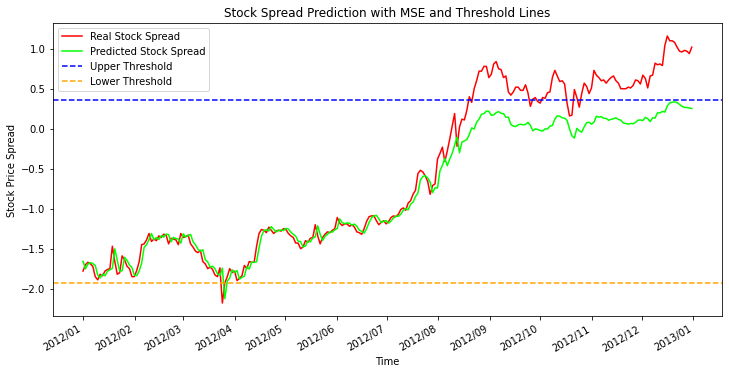

In [27]:
# Return the data for the year 2012.
df_from_excel_2012, real_stock_spread_2012, predicted_stock_spread_2012, stock_code_pair_2012, p_value_pair_2012 = read_and_extract_data_from_excel(2012)
print(f"2012年的 aggressive stock pairs {stock_code_pair_2012} 有最小的 P-value: {p_value_pair_2012}")
plot_stock_spread(real_stock_spread_2012, predicted_stock_spread_2012, '2012-01-01', '2012-12-31')

In [28]:
# Assuming we have the same setup as previously defined
prices_overvalued_2012, prices_undervalued_2012 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2012, stock_code_pair_2012, 2012)
# print it
time_points_2012, ec_2012, initial_capital_2013 = calculate_equity_curve(100, predicted_stock_spread_2012, prices_overvalued_2012, prices_undervalued_2012)

交易天數: 2
年化報酬率: 0.617250074685856%


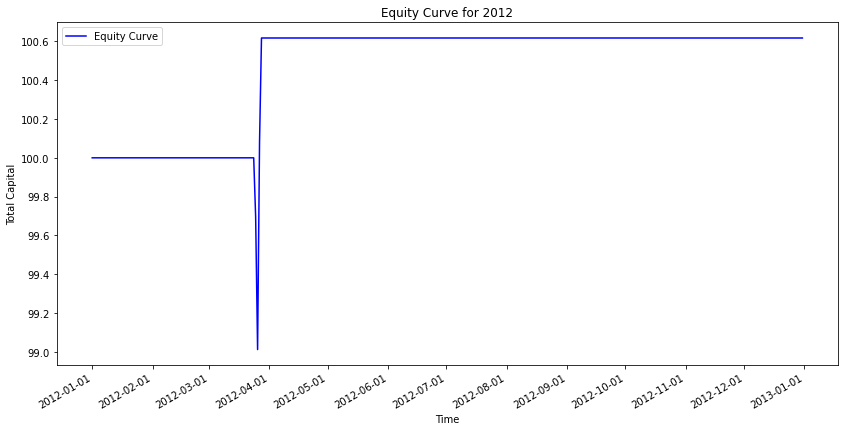

In [29]:
# Generate the curve data for a single year
dates_2012, equity_curve_2012 = generate_yearly_equity_curve(2012, time_points_2012, ec_2012)
# Plot the curve for that single year
plot_equity_curve(dates_2012, equity_curve_2012, 'Equity Curve for 2012')

# 2013

2013年的 aggressive stock pairs ('6150', '1471') 有最小的 P-value: (9.571902316683898e-07, 4.689437996302381e-08)
Mean Squared Error: 0.15618887040108773


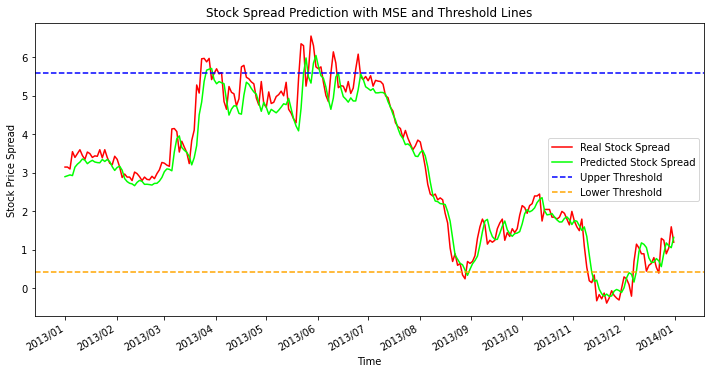

In [30]:
# Return the data for the year 2012.
df_from_excel_2013, real_stock_spread_2013, predicted_stock_spread_2013, stock_code_pair_2013, p_value_pair_2013 = read_and_extract_data_from_excel(2013)
print(f"2013年的 aggressive stock pairs {stock_code_pair_2013} 有最小的 P-value: {p_value_pair_2013}")
plot_stock_spread(real_stock_spread_2013, predicted_stock_spread_2013, '2013-01-01', '2013-12-31')

In [31]:
# Assuming we have the same setup as previously defined
prices_overvalued_2013, prices_undervalued_2013 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2013, stock_code_pair_2013, 2013)
# print it
time_points_2013, ec_2013, initial_capital_2014 = calculate_equity_curve(initial_capital_2013, predicted_stock_spread_2013, prices_overvalued_2013, prices_undervalued_2013)

交易天數: 32
年化報酬率: 12.571275265851476%


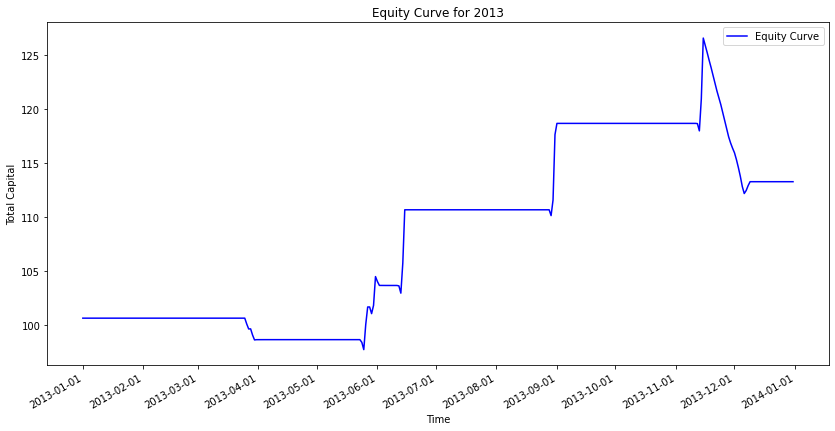

In [32]:
# Generate the curve data for a single year
dates_2013, equity_curve_2013 = generate_yearly_equity_curve(2013, time_points_2013, ec_2013)
# Plot the curve for that single year
plot_equity_curve(dates_2013, equity_curve_2013, 'Equity Curve for 2013')

# 2014

2015年的 aggressive stock pairs ('1605', '3535') 有最小的 P-value: (0.003321999733874977, 0.007074924088832393)
Mean Squared Error: 0.2739792450094731


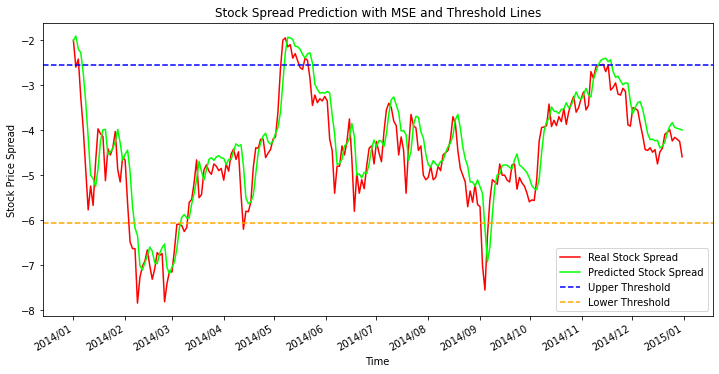

In [33]:
# Return the data for the year 2012.
df_from_excel_2014, real_stock_spread_2014, predicted_stock_spread_2014, stock_code_pair_2014, p_value_pair_2014 = read_and_extract_data_from_excel(2014)
print(f"2015年的 aggressive stock pairs {stock_code_pair_2014} 有最小的 P-value: {p_value_pair_2014}")
plot_stock_spread(real_stock_spread_2014, predicted_stock_spread_2014, '2014-01-01', '2014-12-31')

In [34]:
# Assuming we have the same setup as previously defined
prices_overvalued_2014, prices_undervalued_2014 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2014, stock_code_pair_2014, 2014)
# print it
time_points_2014, ec_2014, initial_capital_2015 = calculate_equity_curve(initial_capital_2014, predicted_stock_spread_2014, prices_overvalued_2014, prices_undervalued_2014)

交易天數: 49
年化報酬率: 84.48626390751848%


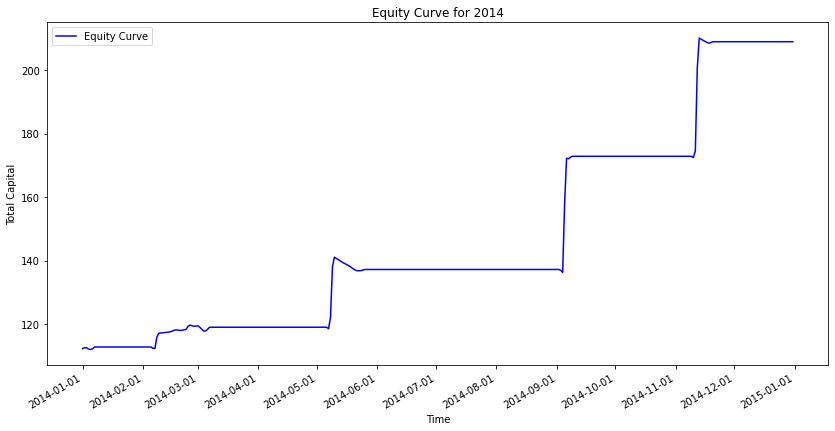

In [35]:
# Generate the curve data for a single year
dates_2014, equity_curve_2014 = generate_yearly_equity_curve(2014, time_points_2014, ec_2014)
# Plot the curve for that single year
plot_equity_curve(dates_2014, equity_curve_2014, 'Equity Curve for 2014')

# 2015

2015年的 aggressive stock pairs ('6022', '8215') 有最小的 P-value: (4.219356311228818e-05, 0.0003961127487096775)
Mean Squared Error: 0.855318901631082


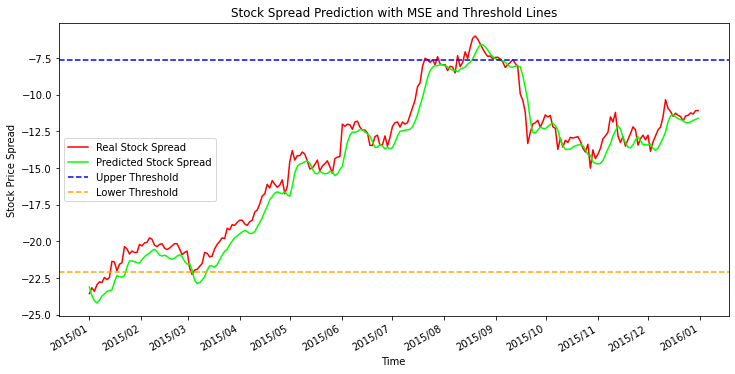

In [36]:
# Return the data for the year 2012.
df_from_excel_2015, real_stock_spread_2015, predicted_stock_spread_2015, stock_code_pair_2015, p_value_pair_2015 = read_and_extract_data_from_excel(2015)
print(f"2015年的 aggressive stock pairs {stock_code_pair_2015} 有最小的 P-value: {p_value_pair_2015}")
plot_stock_spread(real_stock_spread_2015, predicted_stock_spread_2015, '2015-01-01', '2015-12-31')

In [37]:
# Assuming we have the same setup as previously defined
prices_overvalued_2015, prices_undervalued_2015 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2015, stock_code_pair_2015, 2015)
# print it
time_points_2015, ec_2015, initial_capital_2016 = calculate_equity_curve(initial_capital_2015, predicted_stock_spread_2015, prices_overvalued_2015, prices_undervalued_2015)

交易天數: 34
年化報酬率: 35.03618432267922%


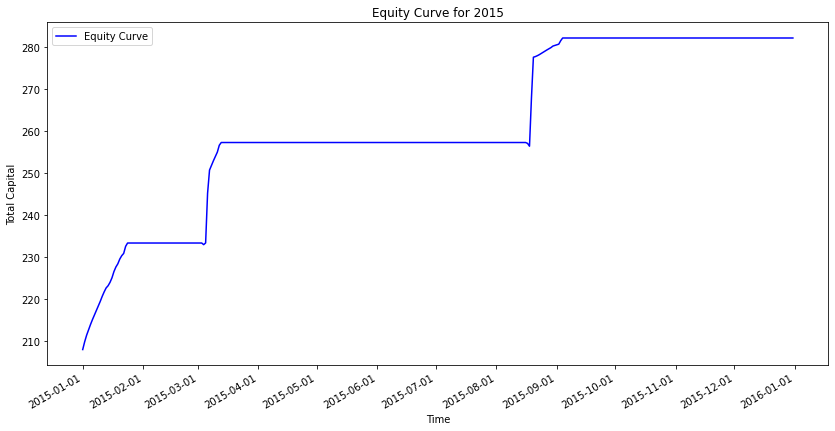

In [38]:
# Generate the curve data for a single year
dates_2015, equity_curve_2015 = generate_yearly_equity_curve(2015, time_points_2015, ec_2015)
# Plot the curve for that single year
plot_equity_curve(dates_2015, equity_curve_2015, 'Equity Curve for 2015')

# 2016

2016年的 aggressive stock pairs ('2207', '5351') 有最小的 P-value: (0.004396097388970065, 0.0003562257552213987)
Mean Squared Error: 31.529691807653634


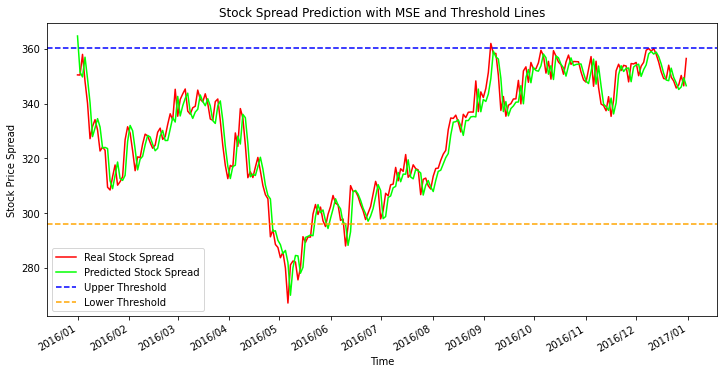

In [39]:
# Return the data for the year 2012.
df_from_excel_2016, real_stock_spread_2016, predicted_stock_spread_2016, stock_code_pair_2016, p_value_pair_2016 = read_and_extract_data_from_excel(2016)
print(f"2016年的 aggressive stock pairs {stock_code_pair_2016} 有最小的 P-value: {p_value_pair_2016}")
plot_stock_spread(real_stock_spread_2016, predicted_stock_spread_2016, '2016-01-01', '2016-12-31')

In [40]:
# Assuming we have the same setup as previously defined
prices_overvalued_2016, prices_undervalued_2016 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2016, stock_code_pair_2016, 2016)
# print it
time_points_2016, ec_2016, initial_capital_2017 = calculate_equity_curve(initial_capital_2016, predicted_stock_spread_2016, prices_overvalued_2016, prices_undervalued_2016)

交易天數: 25
年化報酬率: 7.549825953045598%


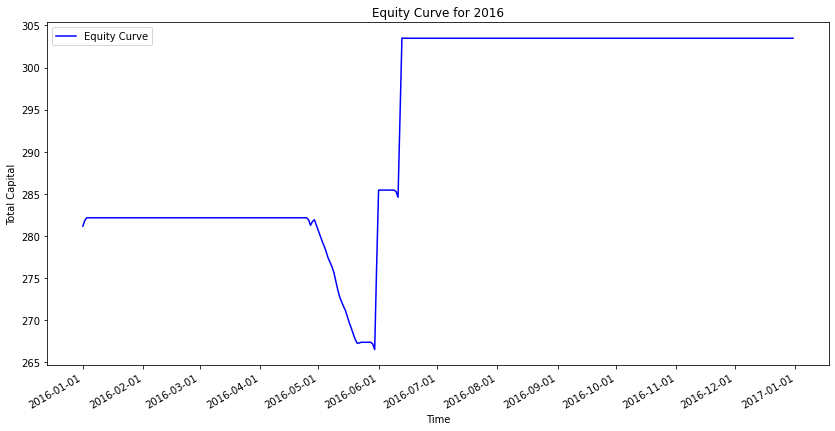

In [41]:
# Generate the curve data for a single year
dates_2016, equity_curve_2016 = generate_yearly_equity_curve(2016, time_points_2016, ec_2016)
# Plot the curve for that single year
plot_equity_curve(dates_2016, equity_curve_2016, 'Equity Curve for 2016')

# 2017

2017年的 aggressive stock pairs ('2439', '8086') 有最小的 P-value: (0.008759172950866607, 0.006815615958813726)
Mean Squared Error: 47.49475669767065


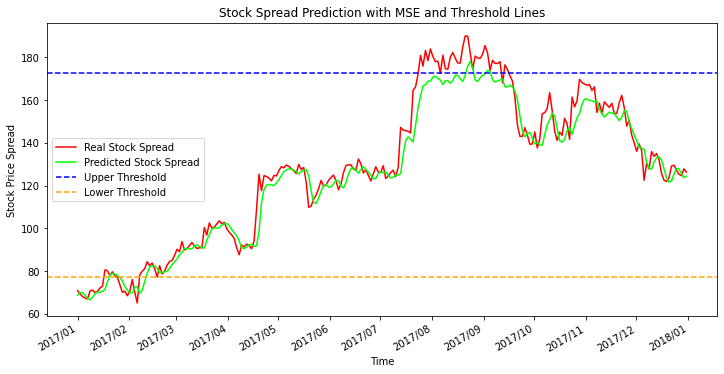

In [42]:
df_from_excel_2017, real_stock_spread_2017, predicted_stock_spread_2017, stock_code_pair_2017, p_value_pair_2017 = read_and_extract_data_from_excel(2017)
print(f"2017年的 aggressive stock pairs {stock_code_pair_2017} 有最小的 P-value: {p_value_pair_2017}")
plot_stock_spread(real_stock_spread_2017, predicted_stock_spread_2017, '2017-01-01', '2017-12-31')

In [43]:
prices_overvalued_2017, prices_undervalued_2017 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2017, stock_code_pair_2017, 2017)
time_points_2017, ec_2017, initial_capital_2018 = calculate_equity_curve(initial_capital_2017, predicted_stock_spread_2017, prices_overvalued_2017, prices_undervalued_2017)

交易天數: 33
年化報酬率: 13.176016452701447%


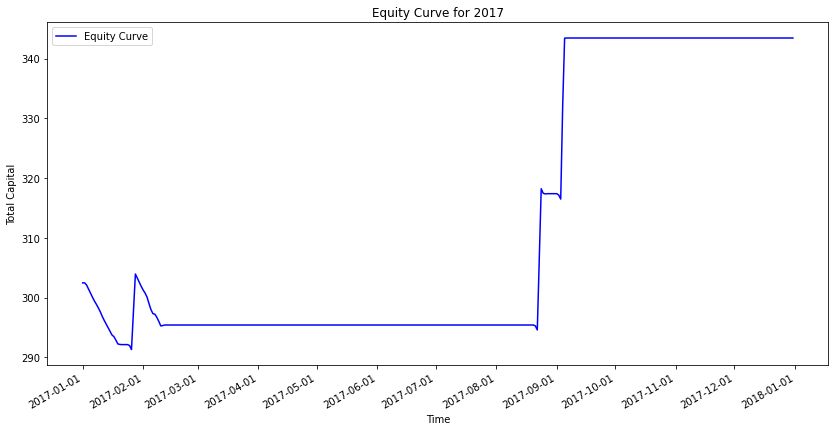

In [44]:
dates_2017, equity_curve_2017 = generate_yearly_equity_curve(2017, time_points_2017, ec_2017)
plot_equity_curve(dates_2017, equity_curve_2017, 'Equity Curve for 2017')

# 2018

2018年的 aggressive stock pairs ('8121', '6243') 有最小的 P-value: (0.0003612176055318661, 0.0002710808988396952)
Mean Squared Error: 0.5528640749014697


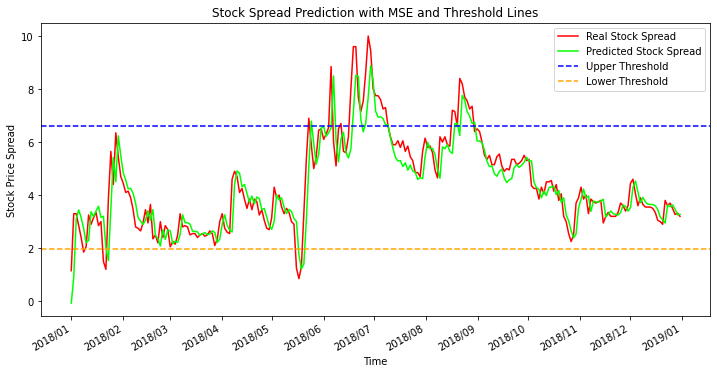

In [45]:
# Return the data for the year 2012.
df_from_excel_2018, real_stock_spread_2018, predicted_stock_spread_2018, stock_code_pair_2018, p_value_pair_2018 = read_and_extract_data_from_excel(2018)
print(f"2018年的 aggressive stock pairs {stock_code_pair_2018} 有最小的 P-value: {p_value_pair_2018}")
plot_stock_spread(real_stock_spread_2018, predicted_stock_spread_2018, '2018-01-01', '2018-12-31')

In [46]:
prices_overvalued_2018, prices_undervalued_2018 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2018, stock_code_pair_2018, 2018)
time_points_2018, ec_2018, initial_capital_2019 = calculate_equity_curve(initial_capital_2018, predicted_stock_spread_2018, prices_overvalued_2018, prices_undervalued_2018)

交易天數: 39
年化報酬率: 18.30203392654192%


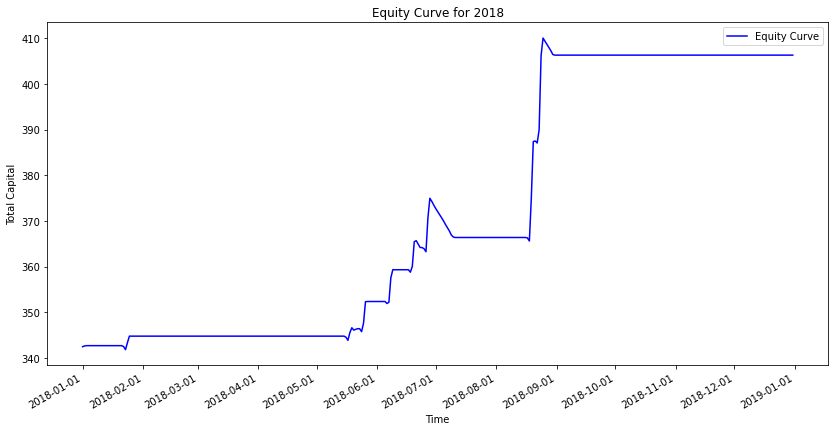

In [47]:
dates_2018, equity_curve_2018 = generate_yearly_equity_curve(2018, time_points_2018, ec_2018)
plot_equity_curve(dates_2018, equity_curve_2018, 'Equity Curve for 2018')

# 2019

2019年的 aggressive stock pairs ('6173', '3016') 有最小的 P-value: (0.0001224217568521067, 2.440106290220734e-05)
Mean Squared Error: 3.1883783546858364


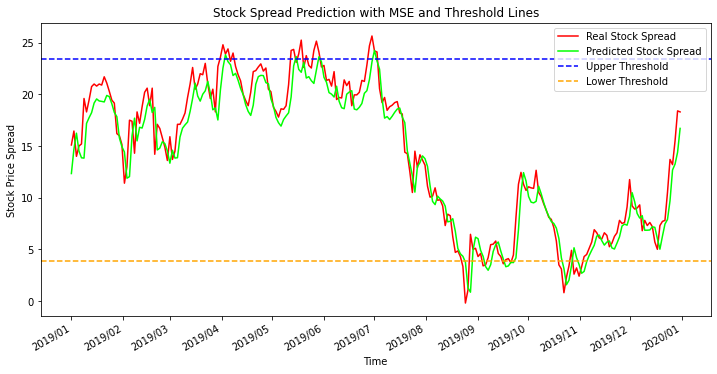

In [48]:
# Return the data for the year 2012.
df_from_excel_2019, real_stock_spread_2019, predicted_stock_spread_2019, stock_code_pair_2019, p_value_pair_2019 = read_and_extract_data_from_excel(2019)
print(f"2019年的 aggressive stock pairs {stock_code_pair_2019} 有最小的 P-value: {p_value_pair_2019}")
plot_stock_spread(real_stock_spread_2019, predicted_stock_spread_2019, '2019-01-01', '2019-12-31')

In [49]:
prices_overvalued_2019, prices_undervalued_2019 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2019, stock_code_pair_2019, 2019)
time_points_2019, ec_2019, initial_capital_2020 = calculate_equity_curve(initial_capital_2019, predicted_stock_spread_2019, prices_overvalued_2019, prices_undervalued_2019)

交易天數: 31
年化報酬率: 11.493814225619905%


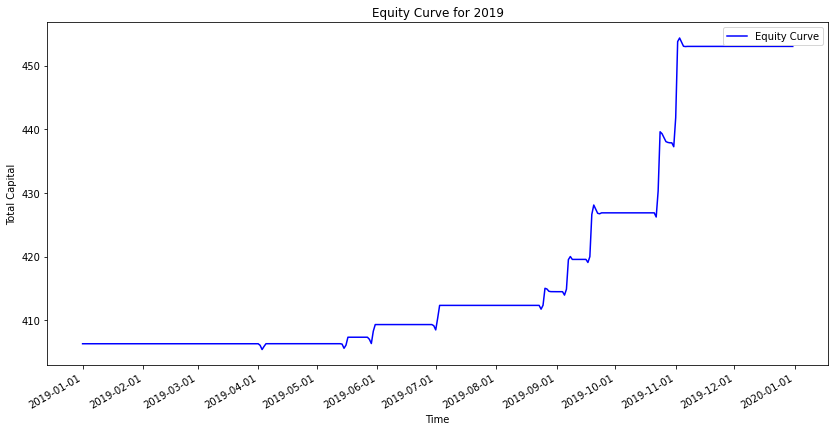

In [50]:
dates_2019, equity_curve_2019 = generate_yearly_equity_curve(2019, time_points_2019, ec_2019)
plot_equity_curve(dates_2019, equity_curve_2019, 'Equity Curve for 2019')

# 2020

2020年的 aggressive stock pairs ('6488', '1597') 有最小的 P-value: (0.0008810052914661338, 0.002256703420629412)
Mean Squared Error: 280.94245861174875


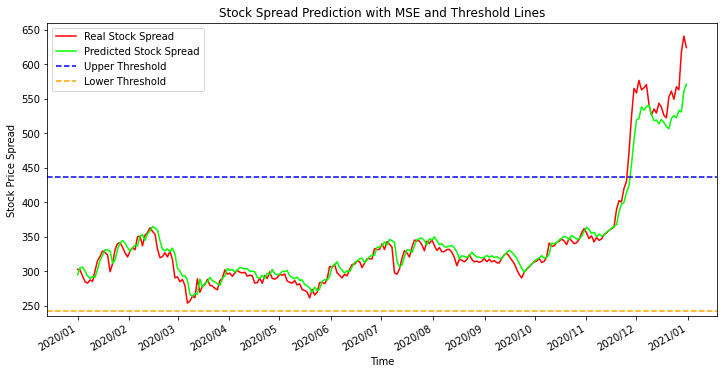

In [51]:
# Return the data for the year 2012.
df_from_excel_2020, real_stock_spread_2020, predicted_stock_spread_2020, stock_code_pair_2020, p_value_pair_2020 = read_and_extract_data_from_excel(2020)
print(f"2020年的 aggressive stock pairs {stock_code_pair_2020} 有最小的 P-value: {p_value_pair_2020}")
plot_stock_spread(real_stock_spread_2020, predicted_stock_spread_2020, '2020-01-01', '2020-12-31')

In [52]:
prices_overvalued_2020, prices_undervalued_2020 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2020, stock_code_pair_2020, 2020)
time_points_2020, ec_2020, initial_capital_2021 = calculate_equity_curve(initial_capital_2020, predicted_stock_spread_2020, prices_overvalued_2020, prices_undervalued_2020)

交易天數: 23
年化報酬率: -3.9722556910797313%


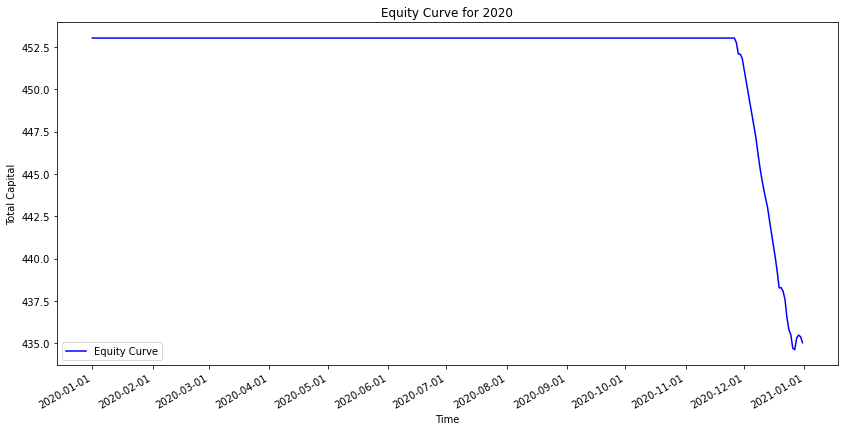

In [53]:
dates_2020, equity_curve_2020 = generate_yearly_equity_curve(2020, time_points_2020, ec_2020)
plot_equity_curve(dates_2020, equity_curve_2020, 'Equity Curve for 2020')

# 2021

2021年的 aggressive stock pairs ('5351', '6284') 有最小的 P-value: (0.005871346128728311, 0.0112726249045524)
Mean Squared Error: 90.45918692829459


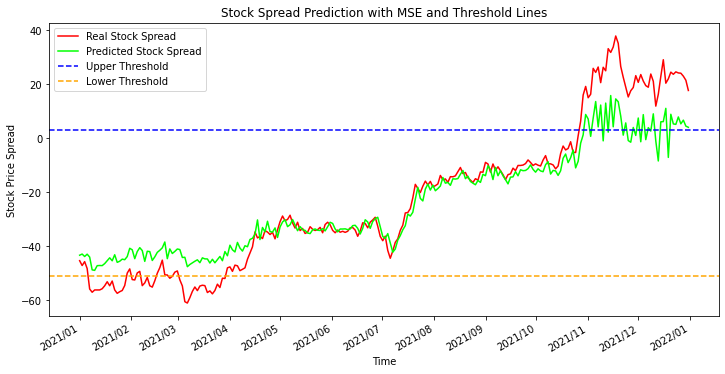

In [54]:
# Return the data for the year 2012.
df_from_excel_2021, real_stock_spread_2021, predicted_stock_spread_2021, stock_code_pair_2021, p_value_pair_2021 = read_and_extract_data_from_excel(2021)
print(f"2021年的 aggressive stock pairs {stock_code_pair_2021} 有最小的 P-value: {p_value_pair_2021}")
plot_stock_spread(real_stock_spread_2021, predicted_stock_spread_2021, '2021-01-01', '2021-12-31')

In [55]:
prices_overvalued_2021, prices_undervalued_2021 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2021, stock_code_pair_2021, 2021)
time_points_2021, ec_2021, initial_capital_2022 = calculate_equity_curve(initial_capital_2021, predicted_stock_spread_2021, prices_overvalued_2021, prices_undervalued_2021)

交易天數: 40
年化報酬率: 29.033528253908454%


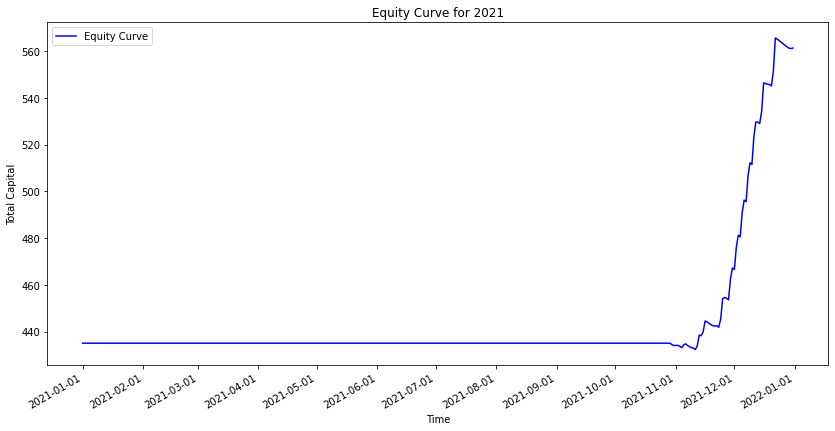

In [56]:
dates_2021, equity_curve_2021 = generate_yearly_equity_curve(2021, time_points_2021, ec_2021)
plot_equity_curve(dates_2021, equity_curve_2021, 'Equity Curve for 2021')

# 2022

2022年的 aggressive stock pairs ('3552', '6284') 有最小的 P-value: (0.003866262480709469, 0.005232219753986547)
Mean Squared Error: 24.671714582306148


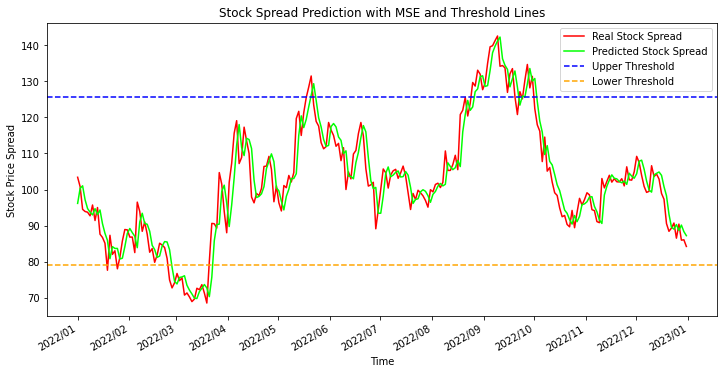

In [57]:
# Return the data for the year 2012.
df_from_excel_2022, real_stock_spread_2022, predicted_stock_spread_2022, stock_code_pair_2022, p_value_pair_2022 = read_and_extract_data_from_excel(2022)
print(f"2022年的 aggressive stock pairs {stock_code_pair_2022} 有最小的 P-value: {p_value_pair_2022}")
plot_stock_spread(real_stock_spread_2022, predicted_stock_spread_2022, '2022-01-01', '2022-12-31')

In [58]:
prices_overvalued_2022, prices_undervalued_2022 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2022, stock_code_pair_2022, 2022)
time_points_2022, ec_2022, initial_capital_2023 = calculate_equity_curve(initial_capital_2022, predicted_stock_spread_2022, prices_overvalued_2022, prices_undervalued_2022)

交易天數: 47
年化報酬率: 6.436546184393639%


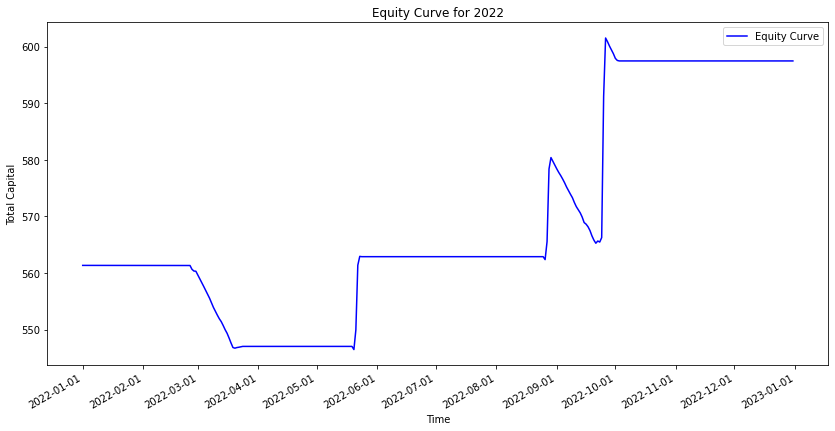

In [59]:
dates_2022, equity_curve_2022 = generate_yearly_equity_curve(2022, time_points_2022, ec_2022)
plot_equity_curve(dates_2022, equity_curve_2022, 'Equity Curve for 2022')

# 2023

2023年的 aggressive stock pairs ('3141', '3189') 有最小的 P-value: (0.002094904910527184, 0.001859883995300552)
Mean Squared Error: 7.116657046742738


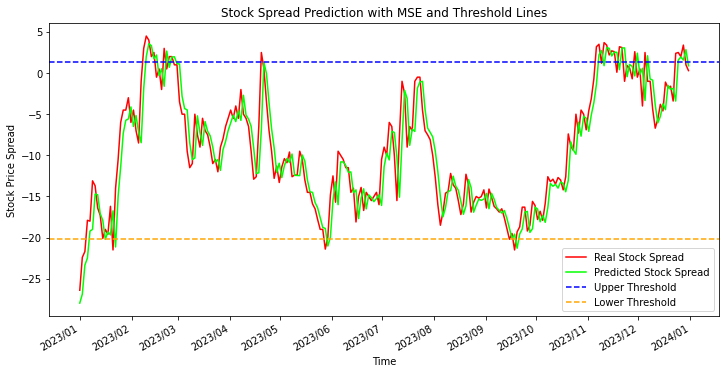

In [60]:
# Return the data for the year 2012.
df_from_excel_2023, real_stock_spread_2023, predicted_stock_spread_2023, stock_code_pair_2023, p_value_pair_2023 = read_and_extract_data_from_excel(2023)
print(f"2023年的 aggressive stock pairs {stock_code_pair_2023} 有最小的 P-value: {p_value_pair_2023}")
plot_stock_spread(real_stock_spread_2023, predicted_stock_spread_2023, '2023-01-01', '2023-12-31')

In [61]:
prices_overvalued_2023, prices_undervalued_2023 = get_overvalued_and_undervalued_stocks(df, predicted_stock_spread_2023, stock_code_pair_2023, 2023)
time_points_2023, ec_2023, final_equity = calculate_equity_curve(initial_capital_2023, predicted_stock_spread_2023, prices_overvalued_2023, prices_undervalued_2023)

交易天數: 45
年化報酬率: 31.54407444186148%


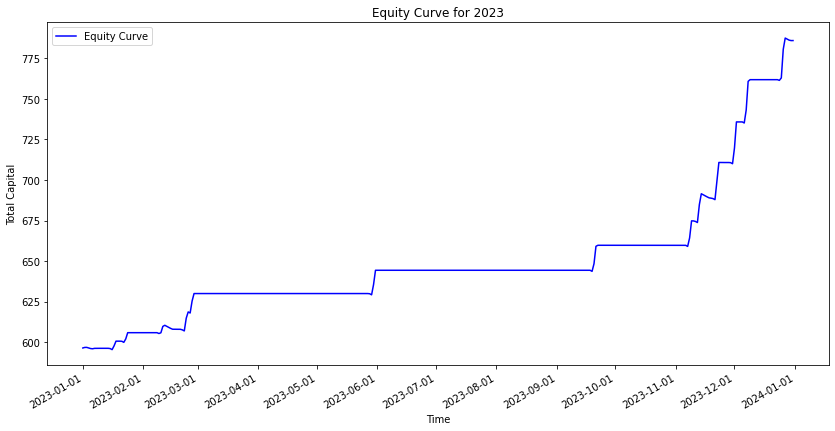

In [112]:
dates_2023, equity_curve_2023 = generate_yearly_equity_curve(2023, time_points_2023, ec_2023)
plot_equity_curve(dates_2023, equity_curve_2023, 'Equity Curve for 2023')

# Final Equity Curve of Aggressive stock pairs

In [143]:
final_return_rate = (final_equity - 100) / 100
print(f"總報酬率：{final_return_rate * 100}%")

總報酬率：685.9278639368002%


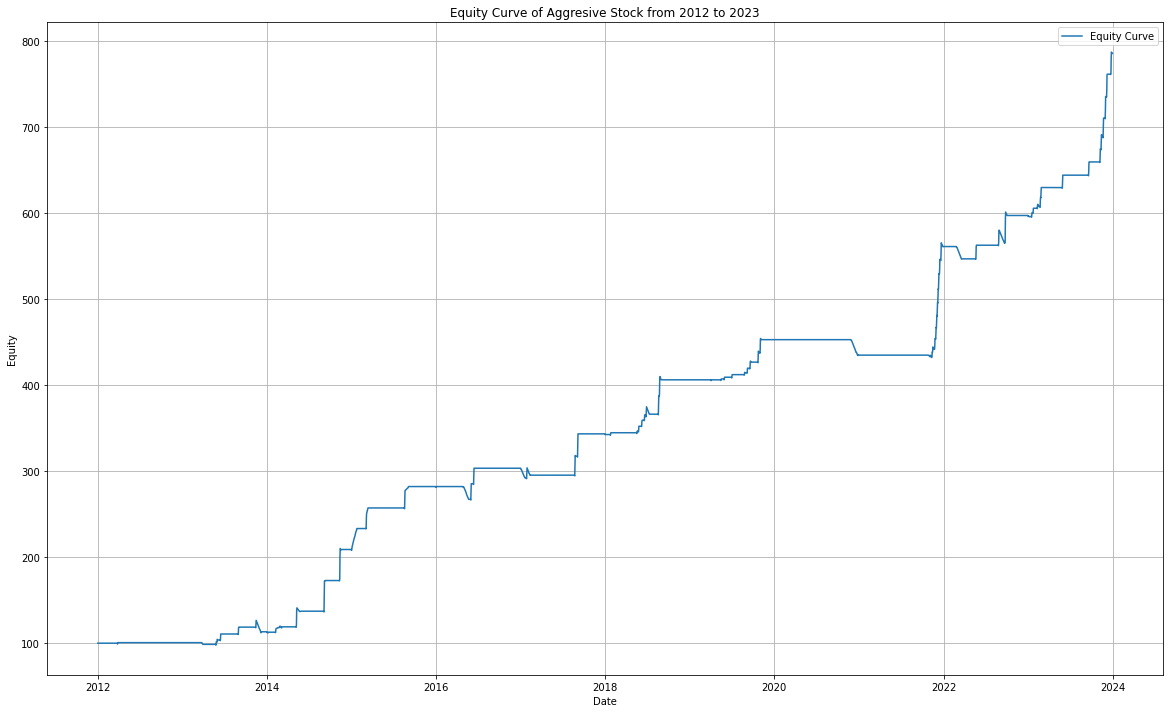

In [144]:
# Create a Pandas DataFrame to hold the data.
all_data = pd.DataFrame()

# Loop through the years for which you have data.
for year in range(2012, 2024):
    # Here you would retrieve the data for the specific year.
    # For now, I am using placeholders.
    if year == 2012:
        dates_time = dates_2012 
        equity_curve = equity_curve_2012  
    elif year == 2013:
        dates_time = dates_2013
        equity_curve = equity_curve_2013
    elif year == 2014:
        dates_time = dates_2014
        equity_curve = equity_curve_2014
    elif year == 2015:
        dates_time = dates_2015
        equity_curve = equity_curve_2015
    elif year == 2016:
        dates_time = dates_2016
        equity_curve = equity_curve_2016
    elif year == 2017:
        dates_time = dates_2017
        equity_curve = equity_curve_2017
    elif year == 2018:
        dates_time = dates_2018
        equity_curve = equity_curve_2018
    elif year == 2019:
        dates_time = dates_2019
        equity_curve = equity_curve_2019
    elif year == 2020:
        dates_time = dates_2020
        equity_curve = equity_curve_2020
    elif year == 2021:
        dates_time = dates_2021
        equity_curve = equity_curve_2021
    elif year == 2022:
        dates_time = dates_2022
        equity_curve = equity_curve_2022
    elif year == 2023:
        dates_time = dates_2023
        equity_curve = equity_curve_2023
    
    # Create a DataFrame for the year's data.
    yearly_data = pd.DataFrame({
        'Date': dates_time,
        'EquityCurve': equity_curve
    })
    
    # Append the yearly data to the all_data DataFrame.
    all_data = pd.concat([all_data, yearly_data], ignore_index=True)

df_to_plot = all_data

# Plot the equity curve.
plt.figure(figsize=(20, 12))
plt.plot(df_to_plot['Date'], df_to_plot['EquityCurve'], label='Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve of Aggresive Stock from 2012 to 2023')
plt.legend()
plt.grid(True)
plt.show()